# Putting some rigor in traditional statistics

Statisticians have long been aware of the problem of over-fitting. When a researcher runs a regression, they typically do so because they want to explore or test a hypothesis about how the world works beyond the data they have at hand.  They are trying to make a finding that *generalizes*. Overfitting is a term that is used to describe cases where a researcher develops a model that fits the data they have very well, but does not generalize to other data. 

Over-fitting can happen in many ways, and the disciplines of traditional statistics and machine learning have developed related methods for dealing with the problem. This week, we are looking at some of the methods that were developed in statistics to address the issue, methods that were further systematized in the field of machine learning. 

## The more data the better

The first thing you need to know is that reliable findings -- findings that generalize -- typically require a lot of data.  The fewer data you have, the greater the risk of non-representation.  Further, the fewer data you have, the easier it is to explain all the statistical variation in the data with a few variables. There are a few rules of thumb about the size of your dataset, but one is that for any number of parameters (variables in your model), you should have at least somewhere between 10x and 50x that number in each of your subsets of data (train, validate, and test).  That typically means an N of at least 50x the number of parameters in your model. So if you have 10 parameters, you should have 500 or more rows of data. 


## Divide and conquer

The second thing that good statisticians do is divide up their data into three data sets, typically (but not always) using a 60/20/20 split on smaller data sets.  (If you have hundreds of thousands or millions of rows, then you can devote smaller portions to validating and testing.)  

The training set, which typically has 60% of the data, is safe for the statistician to explore using any techniques they like. Data mining is allowed and even encouraged.  Why? Becuase any model that is built on the training data will have to be validated on the second set.  And finally, once a model that has been trained and validated, it will then be tested against the third set. 

# Diving In 

In what follows, we'll grab some data and run it through the paces. Next week we will automate all of this and more, but for now, we'll do it by hand, so to speak, so you can see how much having it automated can improve your life. 

## A note of caution

In looking at crime data, we'll want a motivation.  What are we going to *do* with the model.  Let's assume for now that we're working towards a version of PredPol -- the predictive polcing model that we've seen criticized in our readings.  Seeing how these models are developed is useful so that we can give a more sophisticated evaluation of them. Eventually, we'll definitely want to look at it as a time series, and that will give us plenty of data, but we're not quite ready to develop our own super-sophisticated model just yet.  For now, we'll just be running regressions on yearly aggregates from 2010, and that will limit our number of observatios.  Time series, and the problem of how to manage all the data associated with time will come later; the moral and policy problems associated with predicting crime are already up for discussion, but will beome more pointed as the weeks go on.

## Another (more serious) note of caution

As with many historic ills, crime is concentrated in historically disadvantaged communities subject to extended implicit and explicit discrimination.  It is impossible to have a responsible discussion about crime without also talking about the history of redlining, urban neglect by both the private and public sectors (including policing), and the role explicit and implicit bias in driving disproportionate portions of Black and Latino residents into jail.  But what does this mean for us when building a model predicting crime?  If we include race and ethnicity in our model, are we saying -- or letting others infer -- that there is something inherent in the residents those labels describe that is intrinsically more criminal?  Or is it ok to use race and ethnicity as stand-ins for historic discrimination and disadvantage?  There is no simple answer. For this exercise, I'm going to avoid using race and ethnicity as proxies, and try to find other measures of disadvantage.  This will cost me some predictive power, but in the long-run, I think it will make people who use the model less likely to make the kind of improper inferences that can drive bad policy.  

In [5]:
#% matplotlib  inline

In [3]:
# load our packages
##! conda install geopandas -qy
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels as statsm
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt

import seaborn as sns; sns.set(color_codes=True)
import urllib.request
from shapely.geometry import Point


# I've also made a little function for grabbing ACS data via the API. 
# The census data is great, but it's not the easiest to figure out.
# If you want ACS data for your own project, feel free to poach this function.  :-)

def get_acs_2010(varlist):
    if len(varlist) > 50: 
        print('No more than 50 vars can be accessed via the API')
        return
    asv = ','.join(varlist)
    base = 'https://api.census.gov/data/'
    year = '2010/'
    data_set = 'acs5'
    var_list = '''?get=''' + asv 
    for_tract = '&for=tract:*'
    in_state = '&in=state:011'
    in_county = '&in=county:*'
    api_key = '&key=8a94013b188270dc1caf589561d93fbed8091e0a'
    url = base+year+data_set+var_list+for_tract+in_state+in_county+api_key
    with urllib.request.urlopen(url) as f:
         data = eval(f.read().decode('utf-8'))
    acs_df = pd.DataFrame(data[1:],columns=data[0])
    acs_df[varlist] = acs_df[varlist].astype(int)
    acs_df['TRACT'] = acs_df['tract'].astype(str)
    return acs_df


What follows is the kind of data manipulation that is the vast majority of the work of a data scientist. It's not all that fun but we have to do it.  We live for models, but we spend most of our time rearranging data to feed into the models.  

In [3]:
# get our crimes data
crimes = pd.read_csv('https://opendata.arcgis.com/datasets/fdacfbdda7654e06a161352247d3a2f0_34.csv')
crimes = crimes[(crimes['OFFENSE']=='HOMICIDE') | 
                (crimes['OFFENSE']=='ASSAULT W/DANGEROUS WEAPON') |
                (crimes['OFFENSE']=='SEX ABUSE')]

# get some census geojson data
! wget https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson -O census.geojson
census = gpd.read_file('census.geojson')

# merge the crimes data and the census geojson data
geometry = [Point(xy) for xy in zip(crimes.LONGITUDE.apply(float), crimes.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(crimes, crs=crs, geometry=geometry)
geo_crimes = gpd.sjoin(census, points, how='left', op='intersects')

crime_percap = pd.DataFrame(geo_crimes.OBJECTID_left.value_counts()*100000/geo_crimes.P0010001)
crime_percap.columns = ['crime_percap']
tracts_crimes = census.merge(crime_percap, how="left", left_on='OBJECTID', right_index=True)

crime_count = pd.DataFrame(geo_crimes.OBJECTID_left.value_counts())
crime_count.columns = ['crime_count']
tracts_crimes = tracts_crimes.merge(crime_count, how="left", left_on='OBJECTID', right_index=True)
tracts_crimes['population_density'] = tracts_crimes['P0010001'] / tracts_crimes['SQ_MILES']

# get some more census data using the census API and merge it with our other data
#  I'll make a list of variables -- these are all basic age by gender variables
varlist = [('B01001_'+str('%03d' % var)+'E') for var in range(1,50)] 
age_and_sex = get_acs_2010(varlist)

varlist = [('B23009_'+str('%03d' % var)+'E') for var in range(1,44)] 
family = get_acs_2010(varlist)

varlist = [('B17026_'+str('%03d' % var)+'E') for var in range(1,13)] 
poverty = get_acs_2010(varlist)


# now I'll merge this data by tract. 
df = tracts_crimes.merge(age_and_sex, how="left", on='TRACT', )
df = df.merge(poverty, how="left", on='TRACT', )
df = df.merge(family, how="left", on='TRACT', )


--2017-10-05 19:28:40--  https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 34.206.73.45, 52.23.40.223
Connecting to opendata.arcgis.com (opendata.arcgis.com)|34.206.73.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘census.geojson’

census.geojson          [ <=>                ]   1.71M  --.-KB/s    in 0.02s   

2017-10-05 19:28:40 (80.8 MB/s) - ‘census.geojson’ saved [1794478]



# Exercise 01 - try loading some other census data.  

Add any variables you want.  

In [4]:
#list(df.columns)
varlist = [('B25004_'+str('%03d' % var)+'E') for var in range(1,9)] 
vacancy = get_acs_2010(varlist)
df = df.merge(vacancy, how="left", on='TRACT', )

What did you choose to add to the data, and why? 

>**I chose to include vacancy because, to paraphrase Peter, I've seen *The Wire*.**

# Splitting our data

OK, so let's think about this -- we don't have a ton of observations, and we're about to split our data into even small subsamples.  A random spliting of 50 / 25 / 25 would give us roughly 90 observations to train on, 45 for validation, and 45 for testing.  That's really not much. The point of dividing our data is to give us a little more confidence that a result actually will generalize to the real world.  We can probably only afford to have a few parameters in our final model.  So let's do what good statisticians did for a while.  Let's hide away some data, build some promising models, validate them, and then see how they perform on our test data.  

If we had a huge data set, we could do this via random sampling.  But we have relatively little data, and we want to make sure that we get a roughly representative selection of census tracts across the crime-spectrum in each subset. There are fancy ways to do this, but the easiest way is just to sort the data by crime rate, then break it into portions.  So that's what we'll start by doing. 

In [5]:
# first, let's make sure we get data that is sampled across the range of crimes per capita 
# this will ensure that we don't accidentally select 

df = df.sort_values(by='crime_percap').reset_index()
train_mask = list(range(0,180,4))
train_mask = train_mask + list(range(1,180,4))
train_mask.sort()
validate_mask = list(range(2,180,4))
test_mask = list(range(3,180,4))

train = df.loc[train_mask]
validate = df.loc[validate_mask]
test = df.loc[test_mask]


Now that we have our data sets, we can go to town on the training data.  Let's say we want to model criminal incidence.  In the next few weeks, we'll do this using a lot more data spread across time.  But for now, let's just get the basic idea with the data we have at hand.  

One way to figure this sort of thing out is to look at simple correlations in the data we have.  And the easiest way to do that, is to just have a look at what correlates most highly with crime rates.  

# exercise 02 - Examine your correlates 

Type in the following: 

```train.corr()['crime_count'].sort_values()```

What do you see? Anything you think should go into your model? 

In [6]:
train.corr()['crime_count'].sort_values()

B01001_029E          -0.557985
B01001_028E          -0.528127
B23009_002E          -0.500088
B23009_001E          -0.482808
B17026_001E          -0.482808
B01001_043E          -0.478612
B23009_003E          -0.477795
B23009_029E          -0.471980
B17026_012E          -0.464042
FAGI_MEDIAN_2010     -0.452049
B23009_005E          -0.448686
B01001_004E          -0.444381
FAGI_MEDIAN_2013     -0.437351
B01001_005E          -0.436819
B01001_019E          -0.434666
B01001_021E          -0.427199
B17026_011E          -0.422237
B01001_003E          -0.422195
B23009_012E          -0.421857
B01001_027E          -0.420030
B23009_041E          -0.410360
B25004_008E          -0.403617
B01001_044E          -0.400918
B23009_006E          -0.395148
B23009_007E          -0.393078
B01001_042E          -0.389033
B01001_018E          -0.377164
B23009_020E          -0.373466
B23009_018E          -0.373381
B25004_001E          -0.367985
                        ...   
P0040002              0.188263
P0030001

One thing that I can see is that income is very strongly negatively correlated with crime. But if we look deeply at the variables (I won't do that here -- feel free to export to a CSV of the variable descriptions and look through them yourself), there are also a bunch of demographic variables like age, gender, and some housing-related variables like the number of vacant units.  Race is also highly correlated with crime, but my goal right now -- for reasons discussed above -- is to develop a model that doesn't rely on race or ethnicity. 

Variabls negatively correlated with crime are income and older populations: 
- median income  FAGI_MEDIAN_2010
- men over 60 B01001_18E - 25
- women over 60 B01001_42E - 49
- married couples, B23009_024E + B23009_003E

Variables positively correlated with crime:
- vacant properties H0010003
- population under 18 female: B01001_027E B01001_028E B01001_029E B01001_030E male: B01001_003E B01001_004E B01001_005E B01001_006E
- single mothers B23009_018E & B23009_019E 
- single females, no kids B23009_039E 40 & 42 
- high poverty B17026_002E B17026_003E B17026_004E

If you know anything about crime and the criminal justice system, then you know that both are hard on family life.  So it should be unsurprising that crime (and thus involvement in the criminal justice system) are highly correlated with absent fathers, and kids living with non-parents. There is thus a powerful two-way relationship between household structure and crime that mirrors historical disadvantage and mass-incarceration. Here, again, we have to be very careful.  There is a story about people living in low-income high-crime neighborhoods that pays little attention to how poverty, crime, and a dysfunctional criminal justice system can, over decades, pull families and communities apart. Thankfully, a lot of research has turned that story around, and most policy makers are interested in working on reducing improper policing and incarceration rates.  Still, it is worth noting that a model that a model that isn't carefully described could feed into a story that we don't intend to tell. 

And here's a question -- why do you think older men and women are correlated with lower crime rates?  I can think of a few theories -- longevity is another indicator of wealth and community wellbeing; or maybe they pay attention to what is going on in their neighborhood and reign in bad behavior -- and each suggests a different way of thinking about crime and aging. The question I have is whether it matters to the goal of building a (not very sophisticated) PredPol model.  

With those cautions in mind, let's construct some of these variables. 

In [7]:
df['income_log'] = df['FAGI_MEDIAN_2010'].apply(np.log)
df['crimepc_log'] = df['crime_percap'].apply(np.log)
df['crime_log'] = df['crime_count'].apply(np.log)

varlist = [('B01001_'+str('%03d' % var)+'E') for var in range(18,26)] 
df['senior_men'] = df[varlist].astype(int).sum(axis=1 )

varlist = [('B01001_'+str('%03d' % var)+'E') for var in range(42,50)] 
df['senior_women'] = df[varlist].astype(int).sum(axis=1 )

varlist = ['B23009_024E','B23009_003E'] 
df['married_couples'] = df[varlist].astype(int).sum(axis=1 )

varlist = ['H0010003'] 
varlist = ['B25004_008E', 'B25004_007E']  #Wish I had known you already had vacants...
df['vacants'] = df[varlist].astype(int).sum(axis=1 )

varlist = ['B01001_027E','B01001_028E','B01001_029E','B01001_030E','B01001_003E','B01001_004E','B01001_005E','B01001_006E'] 
df['youth'] = df[varlist].astype(int).sum(axis=1 )

varlist = ['B23009_018E','B23009_019E'] # ,'B23009_039E','B23009_040E','B23009_041E','B23009_042E' 
df['solo_women'] = df[varlist].astype(int).sum(axis=1 )

varlist = ['B17026_002E','B17026_003E','B17026_004E'] 
df['high_poverty'] = df[varlist].astype(int).sum(axis=1 )

train = df.loc[train_mask]
validate = df.loc[validate_mask]
test = df.loc[test_mask]


# Exploration with data mining. 

Last week, data mining was the enemy.  It gave us absurd results and models. But this week, we know that we can guard against overfitting by training and validating, and then testing.  

We aren't in the world of real training and testing yet, but let's try to do a little automation.  At this point we have a solid method.  So we can go to town (and you'll learn even better ways to do this soon) in testing out models that we might want to deploy.  Let's return to our simple data mining function (the technical term for it is a regression with "forward selection") from last week.  It just runs through all the additive combinations of the variables to see if any single variable increases the r-squared.  There are still dangers here, but we can afford to be a bit reckless because we'll be disciplined by our validation and test steps. 

In [8]:
def data_mining(data, dv):
    remaining = set(data.columns)
    remaining.remove(dv)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(dv, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print(current_score)
            if score  == 1: 
                print('model overfitted: ' + selected)
    formula = "{} ~ {} + 1".format(dv, ' + '.join(selected))
    print(formula)
    model = smf.ols(formula, data).fit()
    return model

myvars = ['crime_count', 'FAGI_MEDIAN_2010', 'income_log', 'high_poverty', 'vacants', 'population_density',  
          'senior_men', 'senior_women' , 'married_couples', 'youth', 'solo_women']
df_train = pd.DataFrame(train[myvars])
mining = data_mining(df_train,'crime_count')
mining.summary()

print(mining.summary())

0.280106379744
0.40833860162
0.505582652232
0.547564223521
0.62911330998
0.664980361702
0.70817341954
0.736695916648
0.770757159293
crime_count ~ youth + income_log + married_couples + FAGI_MEDIAN_2010 + senior_men + solo_women + senior_women + population_density + vacants + 1
                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     34.25
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           6.97e-24
Time:                        19:28:43   Log-Likelihood:                -30.133
No. Observations:                  90   AIC:                             80.27
Df Residuals:                      80   BIC:                             105.3
Df Model:                           9                                         
Covariance 

>Hooray! By singling out only "Other" and "for migrant workers" vacancy I was able to increase the coef of 'vacants' by ~50%!!

>But does that make the model xenophobic?

# Reviewing the exploratory results

What our forward selection model is telling us is that if we remove any of these parameters, our fit to the data will decrease.  In fancier versions of data mining, we could have it tell us how to drop to successively smaller sets of parameters while preserving the greatest fit.   But we're going to move way beyond this kind of methodology soon, but the approach contains some ideas that we'll be using later. We try to build a model that fits the training data and see if it is robust enough to survive exposure to new data.  

There are a few things that tell me that this is overfitted.  First, if we have four measures of the same thing (income, wealth, poverty), we're going to have a problem in that the specific combination of them is probably highly collinear and likely to cause overfitting. In a more advanced setting, we'd try some version of what is called "dimensionality reduction" that reduces the number of parameters using "principal compenents" or "factors" or "clusters".  All of them find some way of combining (and thus reducing the number of) the parameters involved.  

For now, let's reduce it the old fashioned way: toss some out. The old-fashioned way involves using informed hunches about the data, often built by long exposure to the data and other studies.  

There is a research indicating that concentrated poverty is a serious problem, and concentrated should be even less correlated with (reported) criminality.  For that reason, we may want to interact income and population density.    

There is also research about the way vacancies can lead to crime -- but moreso in low-income neighborhoods.  This differential effect (more powerful in low-income tracts than high-income tracts) makes it another candidate for interaction with income.  


In [9]:
# testing for interaction effects
model = 'crime_count ~  income_log * (population_density + solo_women)  + vacants '
results = smf.ols(model, data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     14.49
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           3.06e-11
Time:                        19:28:43   Log-Likelihood:                -68.963
No. Observations:                  90   AIC:                             151.9
Df Residuals:                      83   BIC:                             169.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Sure enough there are significant interaction effects, and their inclusion increases the r squared and the (lower) AIC & BIC. 

# Exercise 03 - Try playing with different models.  

Add and subtract parameters from your model. Try interacting (putting a * between) some parameters. What happens to teh r-squared?  What happens to the AIC & BIC? 

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     14.49
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           3.06e-11
Time:                        19:28:44   Log-Likelihood:                -68.963
No. Observations:                  90   AIC:                             151.9
Df Residuals:                      83   BIC:                             169.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

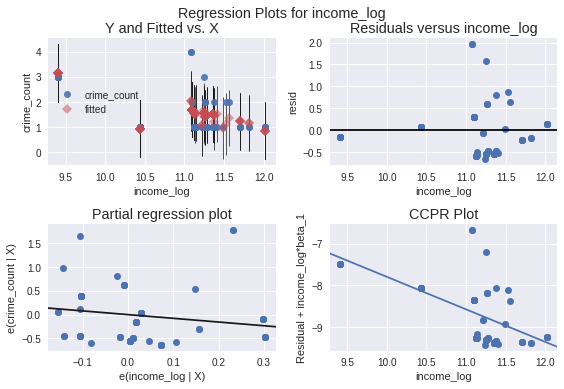

In [10]:
#model += '+ senior_men * senior_women'
results = smf.ols(model, data=train).fit()
print(results.summary())
statsm.graphics.regressionplots.plot_regress_exog(results, 'income_log')

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     13.70
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           9.37e-11
Time:                        19:28:45   Log-Likelihood:                -70.233
No. Observations:                  90   AIC:                             154.5
Df Residuals:                      83   BIC:                             172.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

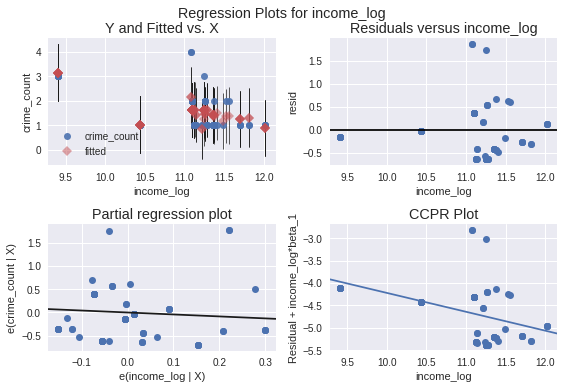

In [11]:
model = 'crime_count ~  income_log * (population_density + vacants)  ' + '+ married_couples'
results = smf.ols(model, data=train).fit()
print(results.summary())
statsm.graphics.regressionplots.plot_regress_exog(results, 'income_log')

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     30.93
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           5.45e-24
Time:                        19:28:46   Log-Likelihood:                -25.641
No. Observations:                  90   AIC:                             75.28
Df Residuals:                      78   BIC:                             105.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

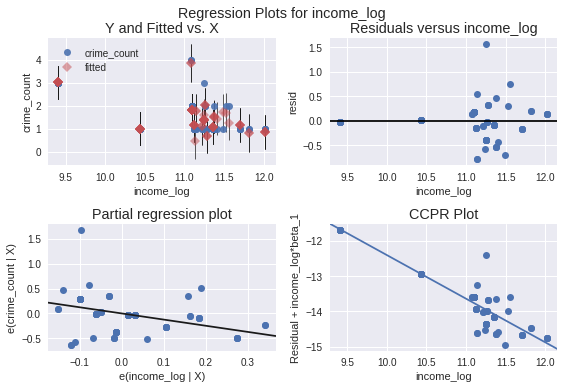

In [12]:
model = 'crime_count ~  income_log * population_density * (solo_women  + vacants) '
results = smf.ols(model, data=train).fit()
print(results.summary())
statsm.graphics.regressionplots.plot_regress_exog(results, 'income_log')

# Exercise 04 - validate your most promising models

Once you have two or three models you want to try out, apply the same method of fitting your model, but this time to the validate dataset.  How does each compare?  Is the adjusted R-squared larger or smaller?  Are the AIC & BIC larger or smaller? 

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     15.20
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           6.43e-10
Time:                        19:28:47   Log-Likelihood:                -10.044
No. Observations:                  45   AIC:                             44.09
Df Residuals:                      33   BIC:                             65.77
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

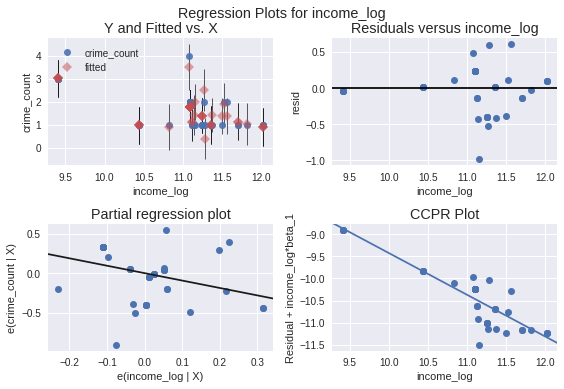

In [13]:
model = 'crime_count ~  income_log * population_density * (solo_women  + vacants) '
results = smf.ols(model, data=validate).fit()
print(results.summary())
statsm.graphics.regressionplots.plot_regress_exog(results, 'income_log')

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     13.70
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           9.37e-11
Time:                        19:28:47   Log-Likelihood:                -70.233
No. Observations:                  90   AIC:                             154.5
Df Residuals:                      83   BIC:                             172.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

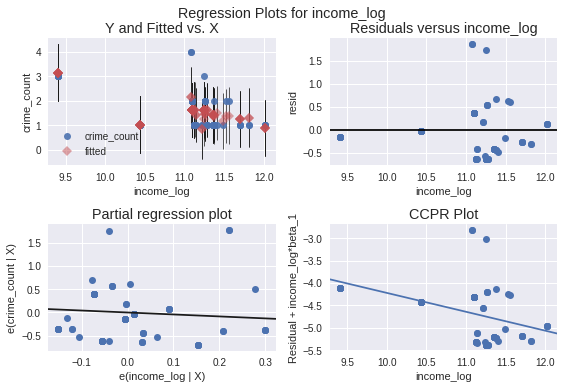

In [14]:
model = 'crime_count ~  income_log * (population_density + vacants)  ' + '+ married_couples'
results = smf.ols(model, data=train).fit()
print(results.summary())
statsm.graphics.regressionplots.plot_regress_exog(results, 'income_log')

# this seems both painfully manual and kinda random

For a long time, this was what it meant to do simple statistical research.  Develop a bunch of models that seems promising, then throw them at a validation data set.  Iterate until you have something you think is relatively robust, then test the hypotheses you've developed against test data.  

Much of this will become automated pretty soon.  Next week in fact.  For now, let's just jump to the conclusion: let's test the model we developed. Since we have our three data sets, let's just change the data from validate to test, and we're good to go. 

# Exercise 05 - fitting to our test data

using the same smf.ols model from above, fit it to the test data, adn print a summary of the results. 

In [15]:
model = 'crime_count ~  income_log * (population_density + solo_women)  + vacants '
results = smf.ols(model, data=test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     7.660
Date:                Thu, 05 Oct 2017   Prob (F-statistic):           1.96e-05
Time:                        19:28:48   Log-Likelihood:                -37.321
No. Observations:                  45   AIC:                             88.64
Df Residuals:                      38   BIC:                             101.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

What do you notice in the results?  Were they what you expected?  How would you judge the quality of our model?  Did we succeed in making a relatively robust model? 

>Unfavorable result! Our R squared was much lower for the test set than the results from the train or validate set.

# Exercise 06 - your data, your model

Now try doing all of this with some of your data. Keep it simple for now.  What are you including in your model?  How do variations on your model compare with one another? 

In [2]:
import zipfile #Kaggle had stock data! I've been looking for this everywhere!

In [4]:
zip_ref = zipfile.ZipFile('../data/nyse.zip', 'r')

zip_ref.extractall(pth)
zip_ref.close()

In [4]:
pth ='../data/nyse/'
fun_df       = pd.read_csv(pth + 'fundamentals.csv')
pri_df       = pd.read_csv(pth + 'prices.csv')
sec_df       = pd.read_csv(pth + 'securities.csv')
spl_df       = pd.read_csv(pth + 'prices-split-adjusted.csv')

In [3]:
spl_df.T

,0,1,2,3,4,5,6,7,8,9,...,851254,851255,851256,851257,851258,851259,851260,851261,851262,851263
date,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-19,...,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30,2016-12-30
symbol,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS,AIV,FTV
open,123.43,125.24,116.38,115.48,117.01,115.51,116.46,113.51,113.33,113.66,...,58.29,8.72,49.98,38.72,63.93,103.31,43.07,53.64,44.73,54.2
close,125.84,119.98,114.95,116.62,114.97,115.55,112.85,114.38,112.53,110.38,...,57.73,8.73,49.52,38.67,63.33,103.2,43.04,53.53,45.45,53.63
low,122.31,119.94,114.93,113.5,114.09,114.5,112.59,110.05,111.92,109.87,...,57.54,8.7,49.36,38.43,63.16,102.85,42.69,53.27,44.41,53.39
high,126.25,125.54,119.74,117.44,117.33,116.06,117.07,115.03,114.88,115.87,...,58.36,8.8,50,39,63.94,103.93,43.31,53.74,45.59,54.48
volume,2.1636e+06,2.3864e+06,2.4895e+06,2.0063e+06,1.4086e+06,1.098e+06,949600,785300,1.0937e+06,1.5235e+06,...,949200,1.12504e+07,646200,6.4316e+06,1.8871e+06,973800,1.9381e+06,1.7012e+06,1.3809e+06,705100


Let's get rid of the penny stocks and check the range of our datetime column.

In [5]:
spl_df['date'] = pd.to_datetime(spl_df['date'], 'coerce', infer_datetime_format=True)

In [19]:
#for i in list(spl_df['symbol'].unique()):
    #i_df = spl_df[spl_df['symbol']==i]
    #if i_df['close'].max() < 3:
        #spl_df = spl_df[spl_df['symbol' != i]]

In [5]:
spl_df.shape #Looks like not many penny stocks

(851264, 7)

In [6]:
spl_df['delta'] = spl_df['open'].sub(spl_df['close'])

In [7]:
spl_df.T

,0,1,2,3,4,5,6,7,8,9,...,851254,851255,851256,851257,851258,851259,851260,851261,851262,851263
date,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-19 00:00:00,...,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00,2016-12-30 00:00:00
symbol,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,WLTW,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS,AIV,FTV
open,123.43,125.24,116.38,115.48,117.01,115.51,116.46,113.51,113.33,113.66,...,58.29,8.72,49.98,38.72,63.93,103.31,43.07,53.64,44.73,54.2
close,125.84,119.98,114.95,116.62,114.97,115.55,112.85,114.38,112.53,110.38,...,57.73,8.73,49.52,38.67,63.33,103.2,43.04,53.53,45.45,53.63
low,122.31,119.94,114.93,113.5,114.09,114.5,112.59,110.05,111.92,109.87,...,57.54,8.7,49.36,38.43,63.16,102.85,42.69,53.27,44.41,53.39
high,126.25,125.54,119.74,117.44,117.33,116.06,117.07,115.03,114.88,115.87,...,58.36,8.8,50,39,63.94,103.93,43.31,53.74,45.59,54.48
volume,2.1636e+06,2.3864e+06,2.4895e+06,2.0063e+06,1.4086e+06,1.098e+06,949600,785300,1.0937e+06,1.5235e+06,...,949200,1.12504e+07,646200,6.4316e+06,1.8871e+06,973800,1.9381e+06,1.7012e+06,1.3809e+06,705100
delta,-2.41,5.26,1.43,-1.14,2.04,-0.040001,3.61,-0.869995,0.800003,3.28001,...,0.560001,-0.01,0.46,0.050003,0.599998,0.110001,0.029999,0.11,-0.720001,0.57


In [7]:
model = 'delta ~ open * (volume + low)'
results = smf.ols(model, data=spl_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                 1.910e+05
Date:                Thu, 05 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:43:44   Log-Likelihood:            -1.1276e+06
No. Observations:              851264   AIC:                         2.255e+06
Df Residuals:                  851258   BIC:                         2.255e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0142      0.002     -7.859      

In [8]:
model = 'delta ~ open + volume + low'
results = smf.ols(model, data=spl_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                 3.161e+05
Date:                Thu, 05 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:43:47   Log-Likelihood:            -1.1291e+06
No. Observations:              851264   AIC:                         2.258e+06
Df Residuals:                  851260   BIC:                         2.258e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0225      0.001    -15.909      0.0

In [12]:
model = 'delta ~  volume * (open * low)'
results = smf.ols(model, data=spl_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                 1.384e+05
Date:                Thu, 05 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:47:55   Log-Likelihood:            -1.1243e+06
No. Observations:              851264   AIC:                         2.249e+06
Df Residuals:                  851256   BIC:                         2.249e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0375      0.002    -

In [13]:
model = 'delta ~  volume * (open * low)'
results = smf.rlm(model, data=spl_df).fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  delta   No. Observations:               851264
Model:                            RLM   Df Residuals:                   851258
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 05 Oct 2017                                         
Time:                        19:48:38                                         
No. Iterations:                    50                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1012      0.001   -1

As expected I have lots of nonzero coef values, low p-values, and vanishingly small stderr values. Unfortunately (but predictably) my R-squared means that these models are never going to make anybody some money on the stock market. The prompt said 'keep it simple' so I'm not going to develop this idea much more than I have.